# Modelling West Nile Virus

In this notebook, we attempt to identify the presence of west nile virus in Chicago.

## Setup

As usual, we begin with importing the necessary libraries and datasets.

### Import Libraries

In [29]:
#for data handling and vizualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gs
import matplotlib.colors as clr
import seaborn as sns
from datetime import datetime
import math

#for modelling
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, FunctionTransformer, MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import RocCurveDisplay


## for spatial visualization
import geopandas as gpd
# import pysal
from geopy import distance
import contextily as cx

pd.set_option("display.max_columns", 250)

### Plotting Setting

In [2]:
# Settings
pd.set_option("display.max_columns", 50)
sns.set_theme(style = 'white')

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

# Palette colors 
p_colors = ["#B84A54", "#49B8AE"]
sns.set_palette(sns.color_palette(p_colors))
# custom continuous cmap based on the 3 colors
rb_cmap = clr.LinearSegmentedColormap.from_list('RB_cmap', ["#49B8AE", "#fffb00", "#B84A54"], N=256)



### Useful Functions
<a id='useful_functions'></a>


In [3]:
# Function to one hot encode multiple columns
def one_hot_encode(df):
    print(df.shape)
    # drop geometry column
    
    #run one-hot enconding for Month, Day, Day of Week features
    onehot_list = ['Year', 'Month','Day of Week', 'Species']
    for onehot in onehot_list:
        df[onehot] = df[onehot].apply(str)
        df = pd.get_dummies(data = df, columns = [onehot], drop_first=True, prefix = onehot)
        
    return df

# Function to generate distance matrix
def generate_distance_matrix(df, df_train, power):
    
    # Get a dataframe containing just the unique traps
    df_unique_traps = df[['Trap', 'Latitude', 'Longitude']].groupby('Trap').first().reset_index().reset_index()
    # Get dataframe containing unique traps from the training set, this is because we only need the distance matrix with regards to the training set
    df_unique_traps_train = df_train[['Trap', 'Latitude', 'Longitude']].groupby('Trap').first().reset_index().reset_index()
    def dist_matrix(row):
        coord_lists = df_unique_traps_train.values
        for coord_list in coord_lists:
            if distance.distance([row['Latitude'], row['Longitude']], [coord_list[2], coord_list[3]]).km != 0:
                row[coord_list[1]+'_dist'] = 1/(distance.distance([row['Latitude'], row['Longitude']], [coord_list[2], coord_list[3]]).km)**power
            else: 
                row[coord_list[1]+'_dist'] = 0
        return row.drop(['index', 'Latitude', 'Longitude'])
    dist_matr = df_unique_traps.apply(dist_matrix, axis = 1)
    
    return df.merge(right = dist_matr, how = 'inner', on = 'Trap')

# Function for a pipeline for hyperparameter tuning of different models
def hyperparam_tuning(feature_sets, response, estimators, use_PCA, useSMOTE, scaler, scoring, refit, cv, verbose):
    """
    Function to find best parameter from a set of feature sets, vectorizers and estimators through gridsearch
    feature_sets = feature sets dictionary in the format {index:dataframe}
    response = Series consisting of the feature labels
    estimators = Estimator dictionary containing estimator instance and parameters
    PCA = True or False - whether to apply PCA before prediction
    scaler = Pass in a scaler instance
    scoring = str of the scoring metric to use for gridsearch
    cv = number of cross validation folds
    verbose= The level of detail of information to print while performing fits
    
    """
    grid_search_result = []

    # loop through the feature sets dict
    for i, feature_set in feature_sets.items():
        print(f"------------------- Feature Set {i} --------------------")
        X = feature_set
        y = response
        #----------------------------------------------------------------------------------
        # loop through the estimators dict
        for estimator_name, estimator_info in estimators.items():
            grid_search_result_row = {} # stores best result of a estimator

            if use_PCA == True and useSMOTE == False: 
                pipe = Pipeline(steps=[('scaler', scaler),
                                       ('PCA', PCA(n_components = 0.95)), 
                                       (estimator_name, estimator_info['estimator'])])
            elif use_PCA == True and useSMOTE == True: 
                pipe = ImbPipeline(steps=[('scaler', scaler),
                                       ('PCA', PCA(n_components = 0.95)),
                                       ('sampling', SMOTE(random_state = 42)),
                                       (estimator_name, estimator_info['estimator'])])
            elif use_PCA == False and useSMOTE == True: 
                pipe = ImbPipeline(steps=[('scaler', scaler),
                                       ('sampling', SMOTE(random_state = 42)),
                                       (estimator_name, estimator_info['estimator'])])
            else: 
                pipe = Pipeline(steps=[('scaler', scaler),
                                       (estimator_name, estimator_info['estimator'])])
                
            # merge the vectorizer and estimator params into a single param grid
            param_grid = estimator_info['params']

            # create gridsearchcv object
            grid_search = GridSearchCV(pipe, param_grid = param_grid, 
                                       scoring = scoring, refit = refit ,verbose = verbose, cv=cv)
            grid_search.fit(X, y) # fit gs object

            # collect the important results
            grid_search_result_row["feature_set"] = i
            grid_search_result_row["estimator"] = estimator_name
            grid_search_result_row["grid search object"] = grid_search
            grid_search_result_row["best estimator"] = grid_search.best_estimator_
            grid_search_result_row["best score"] = grid_search.best_score_
            grid_search_result_row["best params"] = grid_search.best_params_

            print(f"{estimator_name} best {refit} score:", grid_search.best_score_)

            grid_search_result.append(grid_search_result_row)
        
    return grid_search_result

# Function to add rows so that all species have balanced representation
def add_species_rows(df_train, df_val):
    all_species = set(list(train_df_processed['Species'].unique())+list(val_df_processed['Species'].unique()))
    new_df = train_df_processed.head(0)
    for grp in train_df_processed.groupby(by = ['Date', 'Trap']): # for each group, add rows for species not present in the group
        current_group = grp[1]
        species_not_present = all_species.difference(list(grp[1]['Species'].unique()))
        for s in species_not_present:
            row = grp[1].head(1)
            row['Species'] = s
            row['NumMosquitos'] = 0 # for the newly added rows, NumMosquitos =0
            row['WnvPresent'] = 0 # same goes for WnvPresent
            current_group = pd.concat([current_group, row])

        new_df = pd.concat([new_df, current_group])
        
    return new_df

# Function to add if a species is restuans/pipiens
def is_restuans_or_pipiens(row):
    row['is_restuans/pipiens'] = 1 if 'PIPIENS' in row['Species'] or 'RESTUANS' in row['Species'] else 0
    return row 

### Import Datasets

In [118]:
# import cleaned datasets
train_df = pd.read_csv("../../datasets/cleaned_data/train_weather_clean_modelling.csv")
val_df = pd.read_csv("../../datasets/cleaned_data/test_weather_clean.csv")
spray_df = pd.read_csv("../../datasets/cleaned_data/spray_clean.csv")

# Import original datasets
df_train_original = pd.read_csv("../../datasets/original_data/train.csv")
df_test_original = pd.read_csv("../../datasets/original_data/test.csv")
df_spray_original = pd.read_csv("../../datasets/original_data/spray.csv")
df_weather_original = pd.read_csv("../../datasets/original_data/weather.csv")

In [119]:
# We will drop some unnecessary columns that were meant for EDA but not modelling
cols_to_drop_train = ['Station', 'NearestStation', 'geometry', 'Day']

# Drop for train_df
train_df = train_df.drop(columns = cols_to_drop_train)
print(f'train_df: {train_df.shape}')
train_df.head(3)

train_df: (10506, 85)


,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Day of Week,Tmax,Tmin,Tavg,PrecipTotal,Trange,RH,sunlight_hrs,ResultSpeed,is_wet,is_fog,is_smk,Tavg_lag_5,PrecipTotal_lag_5,RH_lag_5,sunlight_hrs_lag_5,ResultSpeed_lag_5,is_wet_lag_5,is_fog_lag_5,is_smk_lag_5,Tavg_lag_6,PrecipTotal_lag_6,RH_lag_6,sunlight_hrs_lag_6,ResultSpeed_lag_6,is_wet_lag_6,is_fog_lag_6,is_smk_lag_6,Tavg_lag_7,PrecipTotal_lag_7,RH_lag_7,sunlight_hrs_lag_7,ResultSpeed_lag_7,is_wet_lag_7,is_fog_lag_7,is_smk_lag_7,Tavg_lag_8,PrecipTotal_lag_8,RH_lag_8,sunlight_hrs_lag_8,ResultSpeed_lag_8,is_wet_lag_8,is_fog_lag_8,is_smk_lag_8,Tavg_lag_9,PrecipTotal_lag_9,RH_lag_9,sunlight_hrs_lag_9,ResultSpeed_lag_9,is_wet_lag_9,is_fog_lag_9,is_smk_lag_9,Tavg_lag_10,PrecipTotal_lag_10,RH_lag_10,sunlight_hrs_lag_10,ResultSpeed_lag_10,is_wet_lag_10,is_fog_lag_10,is_smk_lag_10,Tavg_lag_11,PrecipTotal_lag_11,RH_lag_11,sunlight_hrs_lag_11,ResultSpeed_lag_11,is_wet_lag_11,is_fog_lag_11,is_smk_lag_11,Tavg_lag_12,PrecipTotal_lag_12,RH_lag_12,sunlight_hrs_lag_12,ResultSpeed_lag_12,is_wet_lag_12,is_fog_lag_12,is_smk_lag_12
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,1,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,1,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,5,1,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0


In [120]:
# validation data frame
cols_to_drop_val = ['Station', 'NearestStation', 'Day']
val_df = val_df.drop(columns = cols_to_drop_val)
print(f'val_df: {val_df.shape}')
val_df.head(3)

val_df: (116293, 84)


,Id,Date,Species,Trap,Latitude,Longitude,Year,Month,Day of Week,Tmax,Tmin,Tavg,PrecipTotal,Trange,RH,sunlight_hrs,ResultSpeed,is_wet,is_fog,is_smk,Tavg_lag_5,PrecipTotal_lag_5,RH_lag_5,sunlight_hrs_lag_5,ResultSpeed_lag_5,is_wet_lag_5,is_fog_lag_5,is_smk_lag_5,Tavg_lag_6,PrecipTotal_lag_6,RH_lag_6,sunlight_hrs_lag_6,ResultSpeed_lag_6,is_wet_lag_6,is_fog_lag_6,is_smk_lag_6,Tavg_lag_7,PrecipTotal_lag_7,RH_lag_7,sunlight_hrs_lag_7,ResultSpeed_lag_7,is_wet_lag_7,is_fog_lag_7,is_smk_lag_7,Tavg_lag_8,PrecipTotal_lag_8,RH_lag_8,sunlight_hrs_lag_8,ResultSpeed_lag_8,is_wet_lag_8,is_fog_lag_8,is_smk_lag_8,Tavg_lag_9,PrecipTotal_lag_9,RH_lag_9,sunlight_hrs_lag_9,ResultSpeed_lag_9,is_wet_lag_9,is_fog_lag_9,is_smk_lag_9,Tavg_lag_10,PrecipTotal_lag_10,RH_lag_10,sunlight_hrs_lag_10,ResultSpeed_lag_10,is_wet_lag_10,is_fog_lag_10,is_smk_lag_10,Tavg_lag_11,PrecipTotal_lag_11,RH_lag_11,sunlight_hrs_lag_11,ResultSpeed_lag_11,is_wet_lag_11,is_fog_lag_11,is_smk_lag_11,Tavg_lag_12,PrecipTotal_lag_12,RH_lag_12,sunlight_hrs_lag_12,ResultSpeed_lag_12,is_wet_lag_12,is_fog_lag_12,is_smk_lag_12
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,2,86,61,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,2,86,61,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,2,86,61,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0


---------------------------------------------

## Further Data Processing and Feature Engineering for Modelling

In an attempt to improve the model's accuracy, we will create some added-on features, leveraging the findings from our EDA process.
As an overview, these are the features that will be built.

1. Artifically Adding Species Data
* In the case of the trapped mosquitos, the dataset presented <u>ONLY the data on the trapped mosquitos.</u> In actuality, however, the number of mosquitos from the other species class should have been represented as "zero" rather than not be represented in the training dataset
* Consequentially, it stands to reason that <u>if a mosquito is not found in the trap, the occurence of WNV being present in these species would also be zero</u>.
* <i>Note: this approach, however, assumes that the traps are perfectly representative of the proportion of species, within the vicinity of the trap. While the validity of this assumption is questionable, we shall proceed optimistically assuming that data entry and revalidation is costly. </i>

2. Aggregating Species into "is_restuans/pipiens" 
* From the dataset, we observe that a large proportion of the mosquitoes are classified as either <i>CULEX PIPIENS</i>, <i>CULEX RESTUANS</i>, or both, accounting for <u>over 99.5% of the sample population</u>. 
* We also observe that the remaining species have not been identified to be carriers of the virus. This may prevent our model from generalising towards unseen dataset as other species may also be carriers of the virus. 

3. One-hot encoding for selected existing features
* The 'Month','Day of Week' and 'Species' columns will be turned to a string value, and one-hot encoded as individual columns

4. Generate inverse distance matrix
* As seen from the EDA, the NumMosquitos and WnvPresent follows a geographical pattern, as such, an inverse distance matrix which is indicative of the inverse of the distance of traps from each other will be added. For the validation (test) dataset, we will add add a weighted distance matrix using our predicted NumMosquitos from the regression modelling


### Artifically Adding Species Data

In [121]:
# The training dataset that we will work with
train_df_processed = train_df

In [122]:
# The validation dataset we will work with
val_df_processed = val_df

In [123]:
# Run function to add rows to train df to achieve balanced representation of species
# Commented out after running and exporting resulted dataframe - takes fairly long to run
#train_df_processed = add_species_rows(train_df_processed, val_df_processed)

In [124]:
# Export and import processed datasets
#train_df_processed.to_csv("../../datasets/cleaned_data/train_df_processed_temp.csv", index = False)

In [125]:
train_df_processed = pd.read_csv("../../datasets/cleaned_data/train_df_processed_temp.csv")

In [126]:
train_df_processed.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Day of Week,Tmax,Tmin,Tavg,PrecipTotal,Trange,RH,sunlight_hrs,ResultSpeed,is_wet,is_fog,is_smk,Tavg_lag_5,PrecipTotal_lag_5,RH_lag_5,sunlight_hrs_lag_5,ResultSpeed_lag_5,is_wet_lag_5,is_fog_lag_5,is_smk_lag_5,Tavg_lag_6,PrecipTotal_lag_6,RH_lag_6,sunlight_hrs_lag_6,ResultSpeed_lag_6,is_wet_lag_6,is_fog_lag_6,is_smk_lag_6,Tavg_lag_7,PrecipTotal_lag_7,RH_lag_7,sunlight_hrs_lag_7,ResultSpeed_lag_7,is_wet_lag_7,is_fog_lag_7,is_smk_lag_7,Tavg_lag_8,PrecipTotal_lag_8,RH_lag_8,sunlight_hrs_lag_8,ResultSpeed_lag_8,is_wet_lag_8,is_fog_lag_8,is_smk_lag_8,Tavg_lag_9,PrecipTotal_lag_9,RH_lag_9,sunlight_hrs_lag_9,ResultSpeed_lag_9,is_wet_lag_9,is_fog_lag_9,is_smk_lag_9,Tavg_lag_10,PrecipTotal_lag_10,RH_lag_10,sunlight_hrs_lag_10,ResultSpeed_lag_10,is_wet_lag_10,is_fog_lag_10,is_smk_lag_10,Tavg_lag_11,PrecipTotal_lag_11,RH_lag_11,sunlight_hrs_lag_11,ResultSpeed_lag_11,is_wet_lag_11,is_fog_lag_11,is_smk_lag_11,Tavg_lag_12,PrecipTotal_lag_12,RH_lag_12,sunlight_hrs_lag_12,ResultSpeed_lag_12,is_wet_lag_12,is_fog_lag_12,is_smk_lag_12
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1,0,2007,5,1,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0
1,2007-05-29,CULEX RESTUANS,T002,41.95469,-87.800991,1,0,2007,5,1,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0
2,2007-05-29,CULEX PIPIENS,T002,41.95469,-87.800991,0,0,2007,5,1,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0
3,2007-05-29,UNSPECIFIED CULEX,T002,41.95469,-87.800991,0,0,2007,5,1,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0
4,2007-05-29,CULEX ERRATICUS,T002,41.95469,-87.800991,0,0,2007,5,1,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0


### Aggregating Species into "is_restuans/pipiens"

In [127]:
# Add col for is PIPIENS/RESTUANS
train_df_processed = train_df_processed.apply(is_restuans_or_pipiens, axis = 1)
val_df_processed = val_df_processed.apply(is_restuans_or_pipiens, axis = 1)

In [ ]:
train_df_processed.head(5)

In [ ]:
val_df_processed.head(5)

### One-hot encoding for selected existing features

In [ ]:
### Apply one_hot_encode on training set and validation sets

## Since we have to standardize the one hot encoding for both the train and validation sets, we will first create a merged dataset of train and validation
# First, add a col to both train, val set to indicate whether the row was from train or val set
train_df_processed['Train/Val'] = 'Train'
val_df_processed['Train/Val'] = 'Val'

# Then, we temporary remove the index col from the val set
val_df_processed_temp = val_df_processed.drop(columns = ['Id'])

# Next, we will concatenate both train and val sets
merged_df_temp = pd.concat([train_df_processed, val_df_processed_temp])

# Then, we perform one hot encode on the merged dataframe
merged_df_temp = one_hot_encode(merged_df_temp)

# Again, we split the merged df into train and val set again
train_df_processed = merged_df_temp[merged_df_temp['Train/Val'] == 'Train'].drop(columns = ['Train/Val'])

# For val set, we need to drop two extra cols: NumMosquitos and WnvPresent, and add the Id col back
val_df_processed_temp = merged_df_temp[merged_df_temp['Train/Val'] == 'Val'].drop(columns = ['Train/Val', 'NumMosquitos', 'WnvPresent'])
val_df_processed = pd.concat([val_df_processed['Id'], val_df_processed_temp], axis =1)

In [ ]:
print(train_df_processed.shape)
train_df_processed.head(3)

In [ ]:
print(val_df_processed.shape)
val_df_processed.tail(3)

### Generate inverse distance matrix

In [ ]:
# Apply generate_distance_matrix on train and val set
train_df_processed = generate_distance_matrix(train_df_processed, train_df_processed, power = 1)
val_df_processed = generate_distance_matrix(val_df_processed, train_df_processed, power = 1)

In [ ]:
# Drop the Trap col
train_df_processed = train_df_processed.drop(columns=['Trap'])
val_df_processed = val_df_processed.drop(columns=['Trap'])

In [347]:
print(train_df_processed.shape)
train_df_processed.head()

(38959, 240)


,Date,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,PrecipTotal,Trange,RH,sunlight_hrs,ResultSpeed,is_wet,is_fog,is_smk,Tavg_lag_5,PrecipTotal_lag_5,RH_lag_5,sunlight_hrs_lag_5,ResultSpeed_lag_5,is_wet_lag_5,is_fog_lag_5,is_smk_lag_5,Tavg_lag_6,PrecipTotal_lag_6,RH_lag_6,sunlight_hrs_lag_6,ResultSpeed_lag_6,is_wet_lag_6,is_fog_lag_6,is_smk_lag_6,Tavg_lag_7,PrecipTotal_lag_7,RH_lag_7,sunlight_hrs_lag_7,ResultSpeed_lag_7,is_wet_lag_7,is_fog_lag_7,is_smk_lag_7,Tavg_lag_8,PrecipTotal_lag_8,RH_lag_8,sunlight_hrs_lag_8,ResultSpeed_lag_8,is_wet_lag_8,is_fog_lag_8,is_smk_lag_8,Tavg_lag_9,PrecipTotal_lag_9,RH_lag_9,sunlight_hrs_lag_9,ResultSpeed_lag_9,is_wet_lag_9,is_fog_lag_9,is_smk_lag_9,Tavg_lag_10,PrecipTotal_lag_10,RH_lag_10,sunlight_hrs_lag_10,ResultSpeed_lag_10,is_wet_lag_10,is_fog_lag_10,is_smk_lag_10,Tavg_lag_11,PrecipTotal_lag_11,RH_lag_11,sunlight_hrs_lag_11,ResultSpeed_lag_11,is_wet_lag_11,is_fog_lag_11,is_smk_lag_11,Tavg_lag_12,PrecipTotal_lag_12,RH_lag_12,sunlight_hrs_lag_12,ResultSpeed_lag_12,is_wet_lag_12,is_fog_lag_12,is_smk_lag_12,is_restuans/pipiens,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_5,Month_6,Month_7,Month_8,Month_9,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,T001_dist,T002_dist,T003_dist,T004_dist,T005_dist,T006_dist,T007_dist,T008_dist,T009_dist,T011_dist,T012_dist,T013_dist,T014_dist,T015_dist,T016_dist,T017_dist,T018_dist,T019_dist,T025_dist,T027_dist,T028_dist,T030_dist,T031_dist,T033_dist,T034_dist,T035_dist,T036_dist,T037_dist,T039_dist,T040_dist,T043_dist,T044_dist,T045_dist,T046_dist,T047_dist,T048_dist,T049_dist,T050_dist,T051_dist,T054_dist,T054C_dist,T060_dist,T061_dist,T062_dist,T063_dist,T065_dist,T066_dist,T067_dist,T069_dist,T070_dist,T071_dist,T072_dist,T073_dist,T074_dist,T075_dist,T076_dist,T077_dist,T078_dist,T079_dist,T080_dist,T081_dist,T082_dist,T083_dist,T084_dist,T085_dist,T086_dist,T088_dist,T089_dist,T090_dist,T091_dist,T092_dist,T094_dist,T094B_dist,T095_dist,T096_dist,T097_dist,T099_dist,T100_dist,T102_dist,T103_dist,T107_dist,T114_dist,T115_dist,T128_dist,T129_dist,T135_dist,T138_dist,T141_dist,T142_dist,T143_dist,T144_dist,T145_dist,T146_dist,T147_dist,T148_dist,T149_dist,T150_dist,T151_dist,T152_dist,T153_dist,T154_dist,T155_dist,T156_dist,T157_dist,T158_dist,T159_dist,T160_dist,T161_dist,T162_dist,T200_dist,T206_dist,T209_dist,T212_dist,T215_dist,T218_dist,T219_dist,T220_dist,T221_dist,T222_dist,T223_dist,T224_dist,T225_dist,T226_dist,T227_dist,T228_dist,T229_dist,T230_dist,T231_dist,T232_dist,T233_dist,T235_dist,T236_dist,T237_dist,T238_dist,T900_dist,T903_dist
0,2007-05-29,41.95469,-87.800991,1.0,0.0,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.179938,0.0,0.266855,0.224559,0.404428,0.252113,0.192642,0.159859,0.31404,0.350715,0.165307,0.272014,0.491031,0.342151,0.156714,0.480722,0.076535,0.117392,0.201406,0.145394,0.101122,0.107381,0.057808,0.101706,0.064347,0.060135,0.069683,0.266423,0.128464,0.075867,0.071773,0.089016,0.085128,0.07115,0.077175,0.064163,0.072881,0.103272,0.058934,0.069102,0.070165,0.05614,0.050474,0.053674,0.064055,0.049993,0.045672,0.045088,0.043381,0.057312,0.051673,0.041017,0.038283,0.054205,0.040227,0.042589,0.037817,0.042862,0.034728,0.036825,0.048495,0.046916,0.035352,0.029752,0.034662,0.031913,0.077659,0.034954,0.067992,0.061471,0.05801,0.035349,0.035274,0.034534,0.037336,0.026236,0.031335,0.028951,0.

In [349]:
print(val_df_processed.shape)
val_df_processed.head()

(116293, 239)


,Id,Date,Latitude,Longitude,Tmax,Tmin,Tavg,PrecipTotal,Trange,RH,sunlight_hrs,ResultSpeed,is_wet,is_fog,is_smk,Tavg_lag_5,PrecipTotal_lag_5,RH_lag_5,sunlight_hrs_lag_5,ResultSpeed_lag_5,is_wet_lag_5,is_fog_lag_5,is_smk_lag_5,Tavg_lag_6,PrecipTotal_lag_6,RH_lag_6,sunlight_hrs_lag_6,ResultSpeed_lag_6,is_wet_lag_6,is_fog_lag_6,is_smk_lag_6,Tavg_lag_7,PrecipTotal_lag_7,RH_lag_7,sunlight_hrs_lag_7,ResultSpeed_lag_7,is_wet_lag_7,is_fog_lag_7,is_smk_lag_7,Tavg_lag_8,PrecipTotal_lag_8,RH_lag_8,sunlight_hrs_lag_8,ResultSpeed_lag_8,is_wet_lag_8,is_fog_lag_8,is_smk_lag_8,Tavg_lag_9,PrecipTotal_lag_9,RH_lag_9,sunlight_hrs_lag_9,ResultSpeed_lag_9,is_wet_lag_9,is_fog_lag_9,is_smk_lag_9,Tavg_lag_10,PrecipTotal_lag_10,RH_lag_10,sunlight_hrs_lag_10,ResultSpeed_lag_10,is_wet_lag_10,is_fog_lag_10,is_smk_lag_10,Tavg_lag_11,PrecipTotal_lag_11,RH_lag_11,sunlight_hrs_lag_11,ResultSpeed_lag_11,is_wet_lag_11,is_fog_lag_11,is_smk_lag_11,Tavg_lag_12,PrecipTotal_lag_12,RH_lag_12,sunlight_hrs_lag_12,ResultSpeed_lag_12,is_wet_lag_12,is_fog_lag_12,is_smk_lag_12,is_restuans/pipiens,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_5,Month_6,Month_7,Month_8,Month_9,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,T001_dist,T002_dist,T003_dist,T004_dist,T005_dist,T006_dist,T007_dist,T008_dist,T009_dist,T011_dist,T012_dist,T013_dist,T014_dist,T015_dist,T016_dist,T017_dist,T018_dist,T019_dist,T025_dist,T027_dist,T028_dist,T030_dist,T031_dist,T033_dist,T034_dist,T035_dist,T036_dist,T037_dist,T039_dist,T040_dist,T043_dist,T044_dist,T045_dist,T046_dist,T047_dist,T048_dist,T049_dist,T050_dist,T051_dist,T054_dist,T054C_dist,T060_dist,T061_dist,T062_dist,T063_dist,T065_dist,T066_dist,T067_dist,T069_dist,T070_dist,T071_dist,T072_dist,T073_dist,T074_dist,T075_dist,T076_dist,T077_dist,T078_dist,T079_dist,T080_dist,T081_dist,T082_dist,T083_dist,T084_dist,T085_dist,T086_dist,T088_dist,T089_dist,T090_dist,T091_dist,T092_dist,T094_dist,T094B_dist,T095_dist,T096_dist,T097_dist,T099_dist,T100_dist,T102_dist,T103_dist,T107_dist,T114_dist,T115_dist,T128_dist,T129_dist,T135_dist,T138_dist,T141_dist,T142_dist,T143_dist,T144_dist,T145_dist,T146_dist,T147_dist,T148_dist,T149_dist,T150_dist,T151_dist,T152_dist,T153_dist,T154_dist,T155_dist,T156_dist,T157_dist,T158_dist,T159_dist,T160_dist,T161_dist,T162_dist,T200_dist,T206_dist,T209_dist,T212_dist,T215_dist,T218_dist,T219_dist,T220_dist,T221_dist,T222_dist,T223_dist,T224_dist,T225_dist,T226_dist,T227_dist,T228_dist,T229_dist,T230_dist,T231_dist,T232_dist,T233_dist,T235_dist,T236_dist,T237_dist,T238_dist,T900_dist,T903_dist
0,1,2008-06-11,41.95469,-87.800991,86,61,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.179938,0.0,0.266855,0.224559,0.404428,0.252113,0.192642,0.159859,0.31404,0.350715,0.165307,0.272014,0.491031,0.342151,0.156714,0.480722,0.076535,0.117392,0.201406,0.145394,0.101122,0.107381,0.057808,0.101706,0.064347,0.060135,0.069683,0.266423,0.128464,0.075867,0.071773,0.089016,0.085128,0.07115,0.077175,0.064163,0.072881,0.103272,0.058934,0.069102,0.070165,0.05614,0.050474,0.053674,0.064055,0.049993,0.045672,0.045088,0.043381,0.057312,0.051673,0.041017,0.038283,0.054205,0.040227,0.042589,0.037817,0.042862,0.034728,0.036825,0.048495,0.046916,0.035352,0.029752,0.034662,0.031913,0.077659,0.034954,0.067992,0.061471,0.05801,0.035349,0.035274,0.034534,0.037336,0.026236,0.031335,0.028951,0.035841,0.028105,0.032387,0.0551

### Export the processed dataframes

In [350]:
"""# Export and import processed datasets
train_df_processed.to_csv("../../datasets/cleaned_data/train_df_processed.csv", index = False)
val_df_processed.to_csv("../../datasets/cleaned_data/val_df_processed.csv", index = False)"""

In [90]:
train_df_processed = pd.read_csv("../../datasets/cleaned_data/train_df_processed.csv")
val_df_processed = pd.read_csv("../../datasets/cleaned_data/val_df_processed.csv")

## Modelling

For modelling, we will build a pipeline incorporating the various preprocessing steps. Which will include the following steps.

### Preprocessing

#### Synthetic Minority Oversampling Technique (SMOTE)
In SMOTE, n-nearest neighbours in the minority class is first identified. Subsequently, a line is then drawn between the neighbours, and a sample point is randomly generated on the line. This will address the issue of imbalanced class in our response variable `WnvPresent`.

##### Imbalanced data class

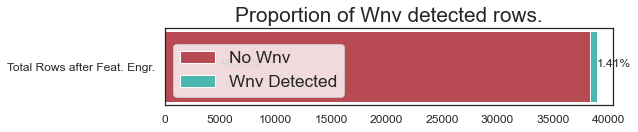

In [91]:
# https://www.tutorialspoint.com/horizontal-stacked-bar-chart-in-matplotlib

header = 'Total Rows after Feat. Engr.'
count_no_wnv, count_wnv = train_df_processed['WnvPresent'].value_counts()
pct_no_wnv, pct_wnv = train_df_processed['WnvPresent'].value_counts(normalize = True)

plt.rcParams["figure.figsize"] = [9, 2]
plt.rcParams["figure.autolayout"] = True
plt.axis(xmax = count_no_wnv + count_wnv + 1500);
plt.title('Proportion of Wnv detected rows.')
b1 = plt.barh(y = header, width = count_no_wnv);
b2 = plt.barh(y = header, width = count_wnv, left = count_no_wnv, color = '#49B8AE')
plt.legend([b1,b2], ['No Wnv','Wnv Detected'], loc = "lower left");

labels = [pct_no_wnv, pct_wnv]
plt.text(x = 5000, y = 0.00025, s = str(round(100*pct_no_wnv,2)) + '%');
plt.text(x = count_no_wnv + count_wnv + 50,
        y = 0.00025,
        s = str(round(100*pct_wnv,2)) + '%');



From the current training data set, we observe that there is a strong class imbalance, where we see that there is an <u>extremely small number of rows where WNV was detected</u>. Just 1.41% of the rows in the data frame make up the WNV detected rows.

From a modelling standpoint, this presents a problem as putting it into the classifier would naturally result in a high number of true negatives (WNV not detected), and underprediction of the true positives (WNV detected) class. Considering the problem statement, this would result in a situation where positive WNV cases go undetected, leading to sudden outbreaks that may be difficult/expensive to control. 

Considering this, we will use SMOTE to conduct oversampling on the <i>Wnv Detected</i> class to balance out the data set.

### The pipeline

The pipeline function can be foound in the [Useful Functions](#useful_functions) section part of this notebook.

### Regression - to obtain NumMosquitos for Validation Set

First, we will use the training set to predict the NumMosquitos features in the validations set.

#### Dataset Preparation

For feature selection purpose, we will create different feature sets containing different combinations of features in order to determine the optimal features to be used for our model.

In [92]:
# Our current training data
train_df_processed.head()

,Date,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,PrecipTotal,Trange,RH,sunlight_hrs,ResultSpeed,is_wet,is_fog,is_smk,Tavg_lag_5,PrecipTotal_lag_5,RH_lag_5,sunlight_hrs_lag_5,ResultSpeed_lag_5,is_wet_lag_5,is_fog_lag_5,is_smk_lag_5,Tavg_lag_6,PrecipTotal_lag_6,RH_lag_6,sunlight_hrs_lag_6,ResultSpeed_lag_6,is_wet_lag_6,is_fog_lag_6,is_smk_lag_6,Tavg_lag_7,PrecipTotal_lag_7,RH_lag_7,sunlight_hrs_lag_7,ResultSpeed_lag_7,is_wet_lag_7,is_fog_lag_7,is_smk_lag_7,Tavg_lag_8,PrecipTotal_lag_8,RH_lag_8,sunlight_hrs_lag_8,ResultSpeed_lag_8,is_wet_lag_8,is_fog_lag_8,is_smk_lag_8,Tavg_lag_9,PrecipTotal_lag_9,RH_lag_9,sunlight_hrs_lag_9,ResultSpeed_lag_9,is_wet_lag_9,is_fog_lag_9,is_smk_lag_9,Tavg_lag_10,PrecipTotal_lag_10,RH_lag_10,sunlight_hrs_lag_10,ResultSpeed_lag_10,is_wet_lag_10,is_fog_lag_10,is_smk_lag_10,Tavg_lag_11,PrecipTotal_lag_11,RH_lag_11,sunlight_hrs_lag_11,ResultSpeed_lag_11,is_wet_lag_11,is_fog_lag_11,is_smk_lag_11,Tavg_lag_12,PrecipTotal_lag_12,RH_lag_12,sunlight_hrs_lag_12,ResultSpeed_lag_12,is_wet_lag_12,is_fog_lag_12,is_smk_lag_12,is_restuans/pipiens,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_5,Month_6,Month_7,Month_8,Month_9,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,T001_dist,T002_dist,T003_dist,T004_dist,T005_dist,T006_dist,T007_dist,T008_dist,T009_dist,T011_dist,T012_dist,T013_dist,T014_dist,T015_dist,T016_dist,T017_dist,T018_dist,T019_dist,T025_dist,T027_dist,T028_dist,T030_dist,T031_dist,T033_dist,T034_dist,T035_dist,T036_dist,T037_dist,T039_dist,T040_dist,T043_dist,T044_dist,T045_dist,T046_dist,T047_dist,T048_dist,T049_dist,T050_dist,T051_dist,T054_dist,T054C_dist,T060_dist,T061_dist,T062_dist,T063_dist,T065_dist,T066_dist,T067_dist,T069_dist,T070_dist,T071_dist,T072_dist,T073_dist,T074_dist,T075_dist,T076_dist,T077_dist,T078_dist,T079_dist,T080_dist,T081_dist,T082_dist,T083_dist,T084_dist,T085_dist,T086_dist,T088_dist,T089_dist,T090_dist,T091_dist,T092_dist,T094_dist,T094B_dist,T095_dist,T096_dist,T097_dist,T099_dist,T100_dist,T102_dist,T103_dist,T107_dist,T114_dist,T115_dist,T128_dist,T129_dist,T135_dist,T138_dist,T141_dist,T142_dist,T143_dist,T144_dist,T145_dist,T146_dist,T147_dist,T148_dist,T149_dist,T150_dist,T151_dist,T152_dist,T153_dist,T154_dist,T155_dist,T156_dist,T157_dist,T158_dist,T159_dist,T160_dist,T161_dist,T162_dist,T200_dist,T206_dist,T209_dist,T212_dist,T215_dist,T218_dist,T219_dist,T220_dist,T221_dist,T222_dist,T223_dist,T224_dist,T225_dist,T226_dist,T227_dist,T228_dist,T229_dist,T230_dist,T231_dist,T232_dist,T233_dist,T235_dist,T236_dist,T237_dist,T238_dist,T900_dist,T903_dist
0,2007-05-29,41.95469,-87.800991,1.0,0.0,88,60,74,0.0,28,57.398449,896.0,-6.316357,0,1,1,76.0,0.02,46.450539,889.0,-16.600558,1.0,0.0,1.0,75.0,0.0,39.928747,887.0,-11.776038,0.0,0.0,0.0,71.0,0.0,40.816283,886.0,-9.911821,0.0,0.0,0.0,62.0,0.0,64.755367,884.0,-0.906649,0.0,0.0,0.0,56.0,0.07,54.874919,882.0,9.58843,1.0,0.0,0.0,68.0,0.0,34.558252,880.0,-7.869152,0.0,0.0,0.0,57.0,0.0,35.568597,878.0,-4.156104,0.0,0.0,0.0,53.0,0.0,44.606027,876.0,10.843139,0.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.179938,0.0,0.266855,0.224559,0.404428,0.252113,0.192642,0.159859,0.31404,0.350715,0.165307,0.272014,0.491031,0.342151,0.156714,0.480722,0.076535,0.117392,0.201406,0.145394,0.101122,0.107381,0.057808,0.101706,0.064347,0.060135,0.069683,0.266423,0.128464,0.075867,0.071773,0.089016,0.085128,0.07115,0.077175,0.064163,0.072881,0.103272,0.058934,0.069102,0.070165,0.05614,0.050474,0.053674,0.064055,0.049993,0.045672,0.045088,0.043381,0.057312,0.051673,0.041017,0.038283,0.054205,0.040227,0.042589,0.037817,0.042862,0.034728,0.036825,0.048495,0.046916,0.035352,0.029752,0.034662,0.031913,0.077659,0.034954,0.067992,0.061471,0.05801,0.035349,0.035274,0.034534,0.037336,0.026236,0.031335,0.028951,0.

In [93]:
# Create Feature Set 0 - no change 
X_train_0 = train_df_processed.drop(columns = ['NumMosquitos', 'WnvPresent', 'Date'])
y_train_0 = train_df_processed['NumMosquitos']

# Create Feature Set 1 - drop Tmax, Tmin
X_train_1 = train_df_processed.drop(columns = ['NumMosquitos', 'WnvPresent', 'Date', 'Tmax', 'Tmin'])
y_train_1 = train_df_processed['NumMosquitos']

# Create Feature Set 2 - drop Day of Week
DoW = [DoW_col for DoW_col in train_df_processed.columns if 'Day of Week' in DoW_col]
X_train_2 = train_df_processed.drop(columns = ['NumMosquitos', 'WnvPresent', 'Date'] + DoW)
y_train_2 = train_df_processed['NumMosquitos']

# Create Feature Set 3 - drop Species
Species_cols = [Spe_col for Spe_col in train_df_processed.columns if 'Species' in Spe_col]
X_train_3 = train_df_processed.drop(columns = ['NumMosquitos', 'WnvPresent', 'Date'] + Species_cols)
y_train_3 = train_df_processed['NumMosquitos']

# Create Feature Set 4 - drop dist matrix
dist_cols = [dist_col for dist_col in train_df_processed.columns if 'dist' in dist_col]
X_train_4 = train_df_processed.drop(columns = ['NumMosquitos', 'WnvPresent', 'Date'] + dist_cols)
y_train_4 = train_df_processed['NumMosquitos']

# Feature Set 5 - drop species and Tmax, Min
X_train_5 = train_df_processed.drop(columns = ['NumMosquitos', 'WnvPresent', 'Date', 'Tmax', 'Tmin'] + Species_cols)
y_train_5 = train_df_processed['NumMosquitos']

In [94]:
## The different feature sets can be placed into a dictionary format to pass into our hyperparameter tuning pipeline
#feature_sets = {0:X_train_0, 1:X_train_1, 2:X_train_2, 3:X_train_3, 4:X_train_4}
feature_sets_r = {0:X_train_1}

#### Hyper-parameter Tuning

First we conduct hyperparameter tuning for some **linear models**, such as linear, poisson, ridge, etc.

In [95]:
# We will first run some linear regression models
estimators_lin = {
    "linear": {'estimator':LinearRegression(), 'params': {}}, 
    "poisson":{'estimator': PoissonRegressor(max_iter = 5000), 'params': {"poisson__alpha": [0.1]}},
    "ridge": {'estimator': Ridge(), 'params': {"ridge__alpha": np.logspace(-1,5,50)}}, 
    "lasso": {'estimator': Lasso(), 'params': {"lasso__alpha": np.logspace(-1,1,5)}}, 
    "enet": {'estimator': ElasticNet(), "params": {"enet__alpha": [0.1], "enet__l1_ratio": [0.1]}},
}

# Linear regressors
scoring = ['neg_root_mean_squared_error'] # gridsearch scoring functions
grid_search_result_R1 = hyperparam_tuning(feature_sets = feature_sets_r, response = y_train_1, 
                                        estimators = estimators_lin, use_PCA = True, useSMOTE = False, scaler = MinMaxScaler(),
                                        scoring = scoring, refit = 'neg_root_mean_squared_error', cv = 5, verbose = 1)

------------------- Feature Set 0 --------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
linear best neg_root_mean_squared_error score: -8.865337143854525
Fitting 5 folds for each of 1 candidates, totalling 5 fits
poisson best neg_root_mean_squared_error score: -8.265361743920224
Fitting 5 folds for each of 50 candidates, totalling 250 fits
ridge best neg_root_mean_squared_error score: -8.777279487663318
Fitting 5 folds for each of 5 candidates, totalling 25 fits
lasso best neg_root_mean_squared_error score: -8.997650476365703
Fitting 5 folds for each of 1 candidates, totalling 5 fits
enet best neg_root_mean_squared_error score: -8.800674624378086


In [96]:
# Dataframe of result
gridsearch_result_R1_df = pd.DataFrame(grid_search_result_R1).sort_values(by = 'best score', ascending = False)

# insert scoring metrics into df
def add_scoring_metrics(row):
    for i, m in enumerate(scoring):
        row[m] = row['grid search object'].cv_results_[f'mean_test_{m}'][0]
    return row
gridsearch_result_R1_df = gridsearch_result_R1_df.apply(add_scoring_metrics, axis = 1)
gridsearch_result_R1_df

,feature_set,estimator,grid search object,best estimator,best score,best params,neg_root_mean_squared_error
1,0,poisson,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Poiss...",-8.265362,{'poisson__alpha': 0.1},-8.265362
2,0,ridge,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Ridge...",-8.777279,{'ridge__alpha': 1456.3484775012444},-8.865305
4,0,enet,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Elast...",-8.800675,"{'enet__alpha': 0.1, 'enet__l1_ratio': 0.1}",-8.800675
0,0,linear,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Linea...",-8.865337,{},-8.865337
3,0,lasso,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Lasso...",-8.997650,{'lasso__alpha': 0.31622776601683794},-9.056277


Then we will do the same for **knn** and **tree-based** regressors such as random forest regressor. 

In [97]:
estimators_tree = {
    "knn": {"estimator": KNeighborsRegressor(), "params": {"knn__n_neighbors": [3, 5, 11, 51, 101], "knn__weights": ['distance']}},
    "rfr": {'estimator':RandomForestRegressor(), 'params': {"rfr__max_depth":[10],
                                                           "rfr__n_estimators":[500]}}
    #"svr": {'estimator': SVR(), 'params': {"svr__C": [0.1, 1, 10],
                                           #"svr__kernel": ['rbf'],
                                           #'svr__degree':[2]}}
}

scoring = ['neg_root_mean_squared_error'] # gridsearch scoring functions
# Knn and tree based regressor
grid_search_result_R2 = hyperparam_tuning(feature_sets = feature_sets_r, response = y_train_1, 
                                        estimators = estimators_tree, use_PCA = False, useSMOTE = False, scaler = StandardScaler(),
                                        scoring = scoring, refit = 'neg_root_mean_squared_error', cv = 5, verbose = 1)

------------------- Feature Set 0 --------------------
Fitting 5 folds for each of 5 candidates, totalling 25 fits
knn best neg_root_mean_squared_error score: -8.519620435332643
Fitting 5 folds for each of 1 candidates, totalling 5 fits
rfr best neg_root_mean_squared_error score: -7.740832795389568


In [100]:
# Dataframe of result
gridsearch_result_R2_df = pd.DataFrame(grid_search_result_R2).sort_values(by = 'best score', ascending = False)

# insert scoring metrics into df
def add_scoring_metrics(row):
    for i, m in enumerate(scoring):
        row[m] = row['grid search object'].cv_results_[f'mean_test_{m}'][0]
    return row
gridsearch_result_R2_df = gridsearch_result_R2_df.apply(add_scoring_metrics, axis = 1)
gridsearch_result_R2_df

,feature_set,estimator,grid search object,best estimator,best score,best params,neg_root_mean_squared_error
1,0,rfr,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), (DecisionTreeRegressor(max_...",-7.740833,"{'rfr__max_depth': 10, 'rfr__n_estimators': 500}",-7.740833
0,0,knn,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(weights...",-8.519620,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",-8.539590


#### Model Evaluation for Regression Model

In [50]:
gridsearch_result_R_df = pd.concat([gridsearch_result_R1_df, gridsearch_result_R2_df]).sort_values(by  = 'neg_root_mean_squared_error', ascending = False).reset_index()
gridsearch_result_R_df['root_mean_squared_error'] = gridsearch_result_R_df['neg_root_mean_squared_error'] *-1
gridsearch_result_R_df

,index,feature_set,estimator,grid search object,best estimator,best score,best params,neg_root_mean_squared_error,root_mean_squared_error
0,1,0,rfr,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), (DecisionTreeRegressor(max_...",-7.734042,"{'rfr__max_depth': 10, 'rfr__n_estimators': 500}",-7.734042,7.734042
1,1,0,poisson,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Poiss...",-8.265362,{'poisson__alpha': 0.1},-8.265362,8.265362
2,0,0,knn,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(weights...",-8.519620,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",-8.539590,8.539590
3,4,0,enet,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Elast...",-8.800675,"{'enet__alpha': 0.1, 'enet__l1_ratio': 0.1}",-8.800675,8.800675
4,2,0,ridge,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Ridge...",-8.777279,{'ridge__alpha': 1456.3484775012444},-8.865305,8.865305
5,0,0,linear,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Linea...",-8.865337,{},-8.865337,8.865337
6,3,0,lasso,"GridSearchCV(cv=5,\n estimator=Pip...","(MinMaxScaler(), PCA(n_components=0.95), Lasso...",-8.997650,{'lasso__alpha': 0.31622776601683794},-9.056277,9.056277


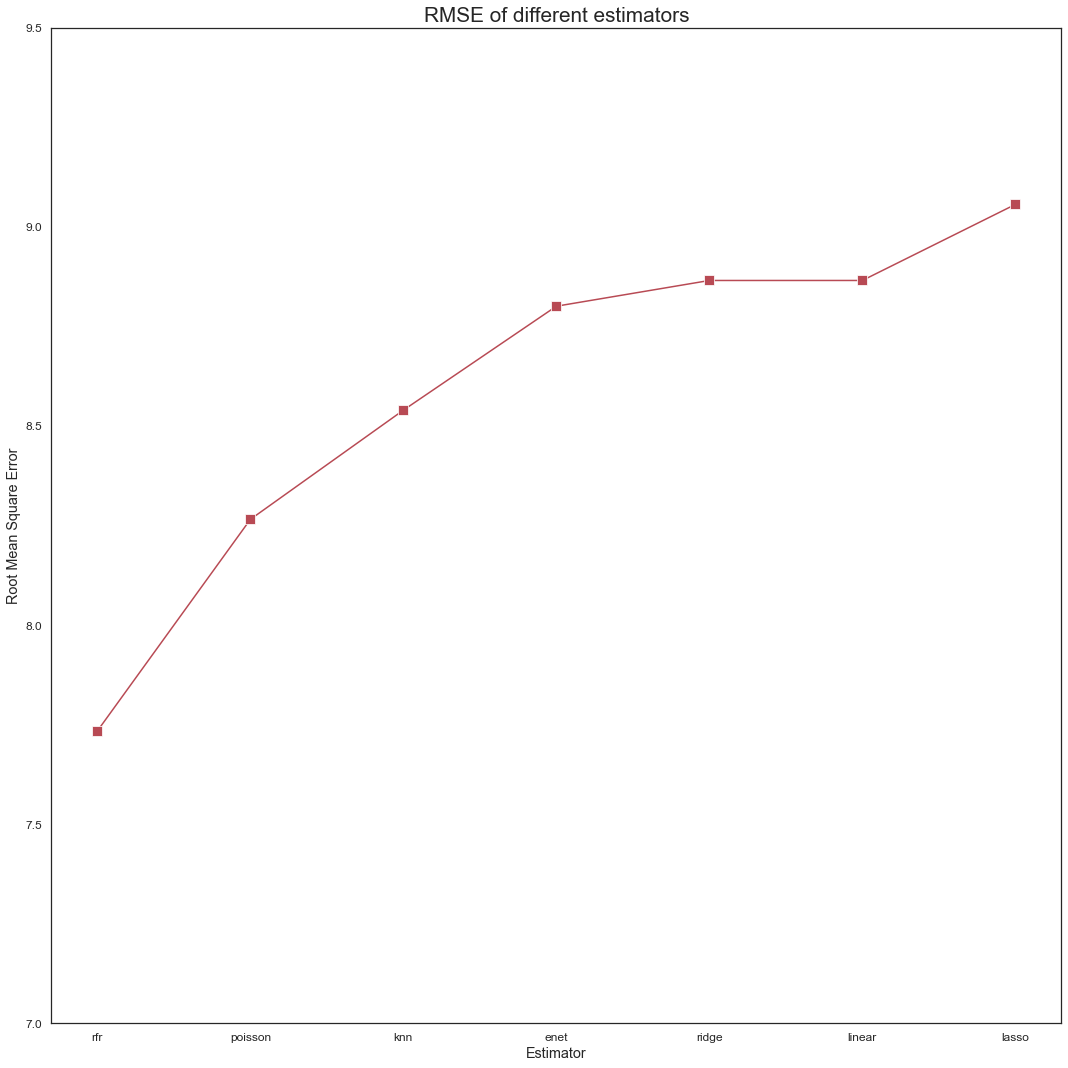

In [101]:
plt.figure(figsize = (15, 15))
sns.lineplot(data = gridsearch_result_R_df, x = 'estimator', 
             y = 'root_mean_squared_error', marker = 's', markersize = 10)
plt.ylim(7, 9.5)
plt.ylabel('Root Mean Square Error')
plt.xlabel('Estimator')
plt.title('RMSE of different estimators');

From the result, it can be seen that the random forest regressor achieved the lowest RMSE of 7.7, we take a look at the distributions of prediction in later section to determine the regression model we will use.

#### Predicting NumMosquitos for validation set

We will predict the NumMosquitos for our validation set using different models just to see the distribution. This helps in evaluating the nest model to be used to predict the NumMosquitos for our validation set.

In [102]:
# Standardize the features for our validation set as our training dataset
X_val = val_df_processed[feature_sets_r[0].columns]

In [108]:
## Predict using different model
#rfr
Xval_predict_rfr = gridsearch_result_R2_df[gridsearch_result_R2_df['estimator'] == 'rfr']['grid search object'].values[0].best_estimator_.predict(X_val)


In [104]:
#knn
Xval_predict_knn = gridsearch_result_R2_df[gridsearch_result_R2_df['estimator'] == 'knn']['grid search object'].values[0].best_estimator_.predict(X_val)


In [105]:
#enet
Xval_predict_enet = gridsearch_result_R1_df[gridsearch_result_R1_df['estimator'] == 'enet']['grid search object'].values[0].best_estimator_.predict(X_val)

In [106]:
#poisson
Xval_predict_poisson = gridsearch_result_R1_df[gridsearch_result_R1_df['estimator'] == 'poisson']['grid search object'].values[0].best_estimator_.predict(X_val)

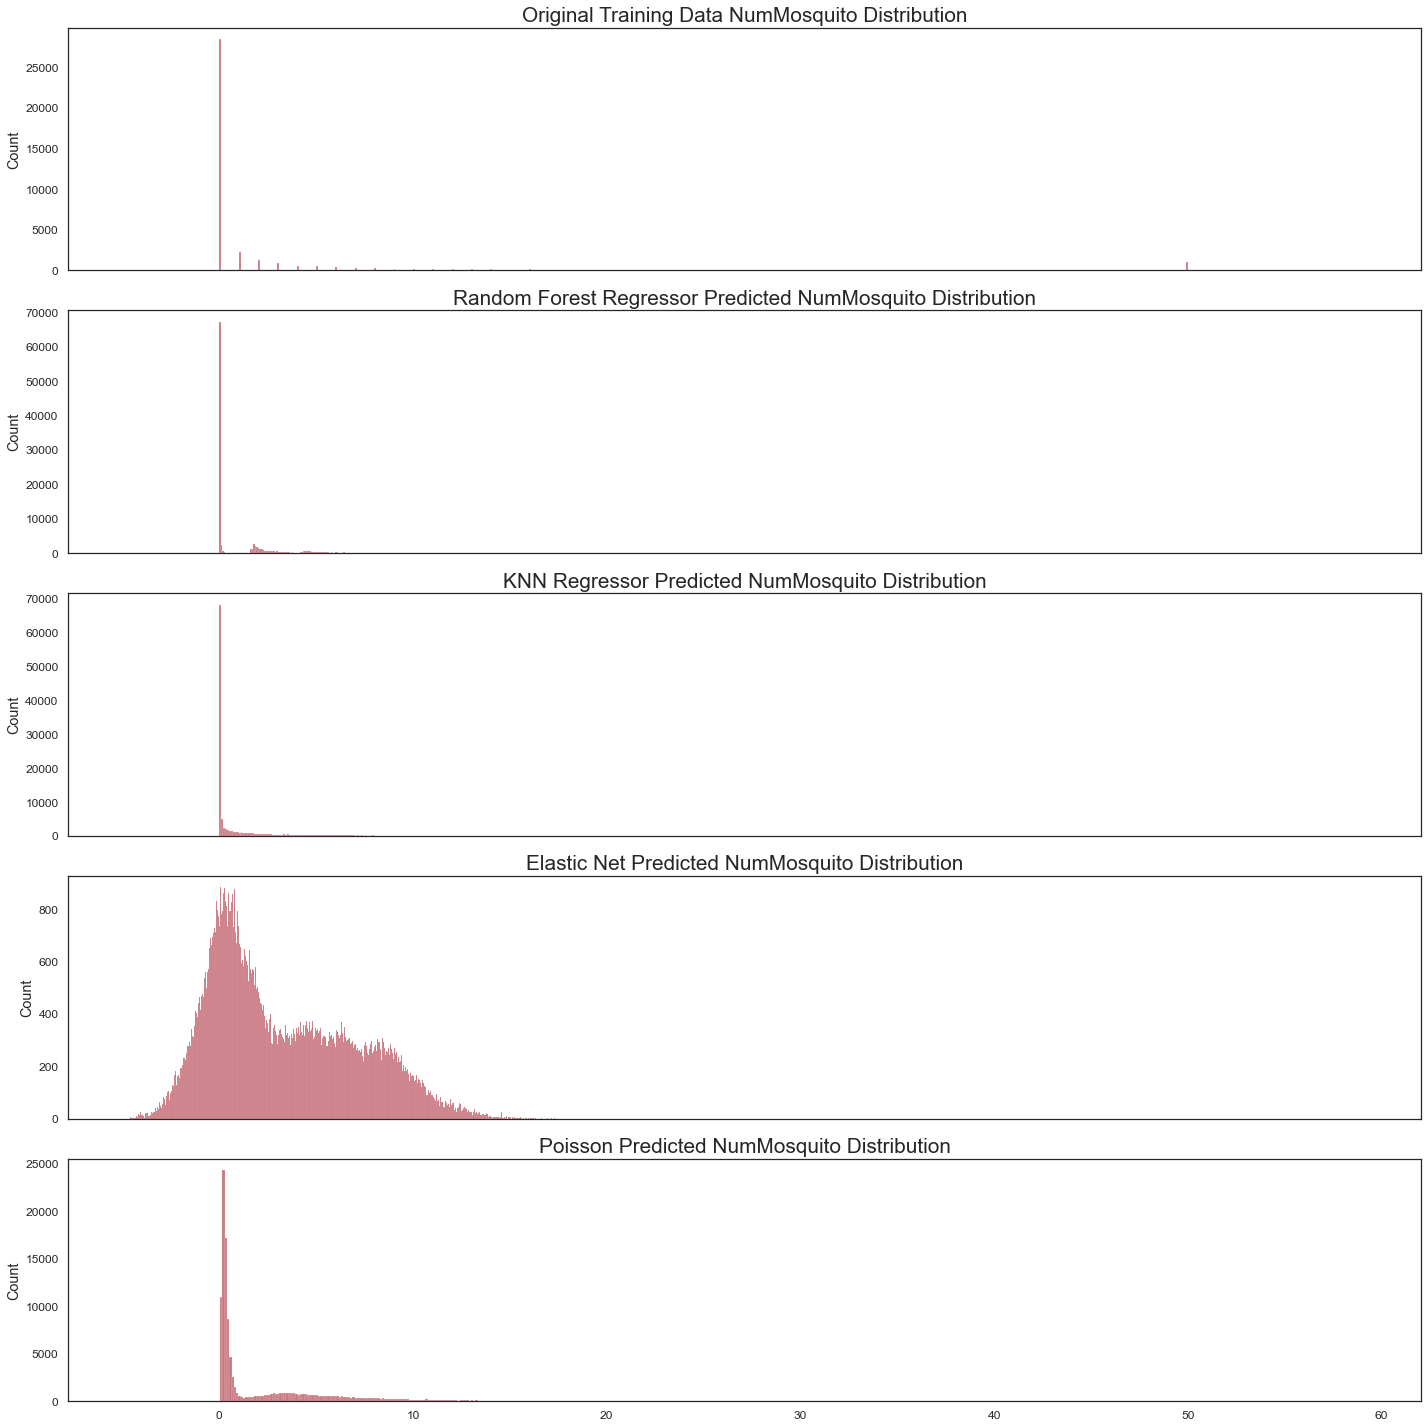

In [114]:
fig, ax = plt.subplots(5,1, figsize = (20, 20), sharex=True)
sns.histplot(train_df_processed['NumMosquitos'], bins = 500, ax = ax[0]) # train NumMos
ax[0].set_title('Original Training Data NumMosquito Distribution')

sns.histplot(Xval_predict_rfr, bins = 500, ax = ax[1]) # rfr
ax[1].set_title('Random Forest Regressor Predicted NumMosquito Distribution')

sns.histplot(Xval_predict_knn, bins = 500, ax = ax[2]) #knn
ax[2].set_title('KNN Regressor Predicted NumMosquito Distribution')

sns.histplot(Xval_predict_enet, bins = 500, ax = ax[3]) #enet
ax[3].set_title('Elastic Net Predicted NumMosquito Distribution')

sns.histplot(Xval_predict_poisson, bins = 500, ax = ax[4]) #poisson
ax[4].set_title('Poisson Predicted NumMosquito Distribution')

plt.tight_layout()

#### Select best regression model

We see that the linear regression models such as the elastic net predicts values that goes below negative, therefore, it is not suited for our purpose. From the distribution of other models, KNN regressor and Random Forest regressor seems to better resemble the distribution of our training set. As the Random Forest regressor achieved a lower RMSE than the KNN regressor, we will choose the **Random Forest regressor** as our model to predict the NumMosquitos for our validation set.

*Note for validation set*: As the validation set has duplicated rows also, it is therefore the case that the max number of mosquitos per row is capped at 50, a recording method same as our training set, therefore, we will change the NumMosquitos for these duplicated rows to 50 as well. 

In [110]:
# Concatenate prediction into X_val df
X_val['NumMosquitos'] = np.round(Xval_predict_rfr, 2)

# Change duplicated rows' NumMosquitos to 50
X_val['Duplicated'] = val_df_processed.drop('Id', axis=1).duplicated()
X_val.loc[X_val['Duplicated'] == True, 'NumMosquitos'] = 50

# Drop Duplicated col
X_val_processed = X_val.drop('Duplicated', axis = 1)
X_val_processed.head()

C:\Users\weiha\AppData\Local\Temp\ipykernel_12196\672114041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['NumMosquitos'] = np.round(Xval_predict_rfr, 2)
C:\Users\weiha\AppData\Local\Temp\ipykernel_12196\672114041.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Duplicated'] = val_df_processed.drop('Id', axis=1).duplicated()


,Latitude,Longitude,Tavg,PrecipTotal,Trange,RH,sunlight_hrs,ResultSpeed,is_wet,is_fog,is_smk,Tavg_lag_5,PrecipTotal_lag_5,RH_lag_5,sunlight_hrs_lag_5,ResultSpeed_lag_5,is_wet_lag_5,is_fog_lag_5,is_smk_lag_5,Tavg_lag_6,PrecipTotal_lag_6,RH_lag_6,sunlight_hrs_lag_6,ResultSpeed_lag_6,is_wet_lag_6,is_fog_lag_6,is_smk_lag_6,Tavg_lag_7,PrecipTotal_lag_7,RH_lag_7,sunlight_hrs_lag_7,ResultSpeed_lag_7,is_wet_lag_7,is_fog_lag_7,is_smk_lag_7,Tavg_lag_8,PrecipTotal_lag_8,RH_lag_8,sunlight_hrs_lag_8,ResultSpeed_lag_8,is_wet_lag_8,is_fog_lag_8,is_smk_lag_8,Tavg_lag_9,PrecipTotal_lag_9,RH_lag_9,sunlight_hrs_lag_9,ResultSpeed_lag_9,is_wet_lag_9,is_fog_lag_9,is_smk_lag_9,Tavg_lag_10,PrecipTotal_lag_10,RH_lag_10,sunlight_hrs_lag_10,ResultSpeed_lag_10,is_wet_lag_10,is_fog_lag_10,is_smk_lag_10,Tavg_lag_11,PrecipTotal_lag_11,RH_lag_11,sunlight_hrs_lag_11,ResultSpeed_lag_11,is_wet_lag_11,is_fog_lag_11,is_smk_lag_11,Tavg_lag_12,PrecipTotal_lag_12,RH_lag_12,sunlight_hrs_lag_12,ResultSpeed_lag_12,is_wet_lag_12,is_fog_lag_12,is_smk_lag_12,is_restuans/pipiens,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_5,Month_6,Month_7,Month_8,Month_9,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,T001_dist,T002_dist,T003_dist,T004_dist,T005_dist,T006_dist,T007_dist,T008_dist,T009_dist,T011_dist,T012_dist,T013_dist,T014_dist,T015_dist,T016_dist,T017_dist,T018_dist,T019_dist,T025_dist,T027_dist,T028_dist,T030_dist,T031_dist,T033_dist,T034_dist,T035_dist,T036_dist,T037_dist,T039_dist,T040_dist,T043_dist,T044_dist,T045_dist,T046_dist,T047_dist,T048_dist,T049_dist,T050_dist,T051_dist,T054_dist,T054C_dist,T060_dist,T061_dist,T062_dist,T063_dist,T065_dist,T066_dist,T067_dist,T069_dist,T070_dist,T071_dist,T072_dist,T073_dist,T074_dist,T075_dist,T076_dist,T077_dist,T078_dist,T079_dist,T080_dist,T081_dist,T082_dist,T083_dist,T084_dist,T085_dist,T086_dist,T088_dist,T089_dist,T090_dist,T091_dist,T092_dist,T094_dist,T094B_dist,T095_dist,T096_dist,T097_dist,T099_dist,T100_dist,T102_dist,T103_dist,T107_dist,T114_dist,T115_dist,T128_dist,T129_dist,T135_dist,T138_dist,T141_dist,T142_dist,T143_dist,T144_dist,T145_dist,T146_dist,T147_dist,T148_dist,T149_dist,T150_dist,T151_dist,T152_dist,T153_dist,T154_dist,T155_dist,T156_dist,T157_dist,T158_dist,T159_dist,T160_dist,T161_dist,T162_dist,T200_dist,T206_dist,T209_dist,T212_dist,T215_dist,T218_dist,T219_dist,T220_dist,T221_dist,T222_dist,T223_dist,T224_dist,T225_dist,T226_dist,T227_dist,T228_dist,T229_dist,T230_dist,T231_dist,T232_dist,T233_dist,T235_dist,T236_dist,T237_dist,T238_dist,T900_dist,T903_dist,NumMosquitos
0,41.95469,-87.800991,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.179938,0.0,0.266855,0.224559,0.404428,0.252113,0.192642,0.159859,0.31404,0.350715,0.165307,0.272014,0.491031,0.342151,0.156714,0.480722,0.076535,0.117392,0.201406,0.145394,0.101122,0.107381,0.057808,0.101706,0.064347,0.060135,0.069683,0.266423,0.128464,0.075867,0.071773,0.089016,0.085128,0.07115,0.077175,0.064163,0.072881,0.103272,0.058934,0.069102,0.070165,0.05614,0.050474,0.053674,0.064055,0.049993,0.045672,0.045088,0.043381,0.057312,0.051673,0.041017,0.038283,0.054205,0.040227,0.042589,0.037817,0.042862,0.034728,0.036825,0.048495,0.046916,0.035352,0.029752,0.034662,0.031913,0.077659,0.034954,0.067992,0.061471,0.05801,0.035349,0.035274,0.034534,0.037336,0.026236,0.031335,0.028951,0.035841,0.028105,0.032387,0.055167,0.028224,0.029438,0.0

#### Regression Model Feature Importance

In [16]:
# Top 20
feature_impt_reg = pd.DataFrame({'Feature':X_train_1.columns, 'Feature Importance': gridsearch_result_R2_df.iloc[0,:]["grid search object"].best_estimator_.named_steps['rfr'].feature_importances_}).sort_values(by = 'Feature Importance', ascending = False)
feature_impt_reg.head(20)

,Feature,Feature Importance
75,is_restuans/pipiens,0.230322
233,T900_dist,0.156994
93,Species_CULEX PIPIENS/RESTUANS,0.042364
94,Species_CULEX RESTUANS,0.039530
2,Tavg,0.029920
178,T103_dist,0.028029
162,T084_dist,0.025602
27,Tavg_lag_7,0.021280
181,T115_dist,0.018004
92,Species_CULEX PIPIENS,0.013191


### Classification to obtain NumMosquitos for Validation Set

#### Dataset Preparation

Similar to the regression modelling, we will prepare different datasets for our classification as well.

As we have our NumMosquitos for both training and validation sets, we will weigh our distance matrix by the NumMosquitos, this is so that traps with a higher NumMosquitos will have a higher weight.

In [24]:
### Create feature sets for classification
y_train_c = train_df_processed['WnvPresent']

## Feature set 0
X_train_c_0 = train_df_processed.drop(columns = ['WnvPresent', 'Date'])
X_val_c_0 = X_val_processed

## Feature set 1 - multiply dist matrix by NumMosquitos, drop species and Tmin, Tmax
dist_cols = [dist_col for dist_col in train_df_processed.columns if 'dist' in dist_col]
# train
X_train_c_1 = train_df_processed 
X_train_c_1[dist_cols] = X_train_c_1[dist_cols].mul(X_train_c_1['NumMosquitos']+1, axis = 0)
X_train_c_1 = X_train_c_1.drop(columns = ['WnvPresent', 'Date'])

# validation
X_val_c_1 = X_val_processed
X_val_c_1[dist_cols] = X_val_c_1[dist_cols].mul(X_val_c_1['NumMosquitos']+1, axis = 0)

#Drop species, Tmin, Tmax
Species_cols = [Spe_col for Spe_col in X_train_c_1.columns if 'Species' in Spe_col] # drop species
X_train_c_1 = X_train_c_1.drop(columns = Species_cols+['is_restuans/pipiens', 'Tmin', 'Tmax'])
X_val_c_1 = X_val_c_1.drop(columns = Species_cols+['is_restuans/pipiens'])

In [67]:
#X_train_cs_1, X_test_cs_1, y_train_cs_1, y_test_cs_1 = train_test_split(X_train_c_1,y_train_c.values, test_size = 0.1, stratify = y_train_c.values)

In [25]:
#feature_sets_c = {0:X_train_cs_1}

In [27]:
estimators = {
    "logreg": {'estimator':LogisticRegression(random_state=1, max_iter=5000), 
               'params': {'logreg__C' : [0.01, 0.1, 1, 10]}},
    "gb": {'estimator': GradientBoostingClassifier(random_state=1), 
           'params': {"gb__max_depth": [3],
                      'gb__n_estimators': [200],
                      'gb__learning_rate': [0.1]}},
     "rf": {'estimator': RandomForestClassifier(random_state=1), 
           'params': {"rf__n_estimators": [500], 
                      'rf__max_depth': [10]}}
}


scoring = ['roc_auc', 'accuracy', 'recall', 'precision', 'f1'] # gridsearch scoring functions
# Knn and tree based regressor

grid_search_result_C1 = hyperparam_tuning(feature_sets = feature_sets_c, response = y_train_cs_1, 
                                        estimators = estimators, use_PCA = False, useSMOTE = True, scaler = StandardScaler(),
                                        scoring = scoring, refit = 'roc_auc', cv = 5, verbose = 1)

------------------- Feature Set 0 --------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits
logreg best roc_auc score: 0.7659249159298126
Fitting 5 folds for each of 1 candidates, totalling 5 fits
gb best roc_auc score: 0.9315691974522403
Fitting 5 folds for each of 1 candidates, totalling 5 fits
rf best roc_auc score: 0.9086058323963462


#### Model Evaluation for Classification Model

In [28]:
# Dataframe of result
gridsearch_result_C1_df = pd.DataFrame(grid_search_result_C1).sort_values(by = 'best score', ascending = False)

# insert scoring metrics into df
def add_scoring_metrics(row):
    for i, m in enumerate(scoring):
        row[m] = row['grid search object'].cv_results_[f'mean_test_{m}'][0]
    return row
gridsearch_result_C1_df = gridsearch_result_C1_df.apply(add_scoring_metrics, axis = 1)
gridsearch_result_C1_df

,feature_set,estimator,grid search object,best estimator,best score,best params,roc_auc,accuracy,recall,precision,f1
1,0,gb,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), SMOTE(random_state=42), ([D...",0.931569,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3,...",0.931569,0.929463,0.553857,0.127225,0.201577
2,0,rf,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), SMOTE(random_state=42), (De...",0.908606,"{'rf__max_depth': 10, 'rf__n_estimators': 500}",0.908606,0.928822,0.695414,0.143358,0.234142
0,0,logreg,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), SMOTE(random_state=42), Log...",0.765925,{'logreg__C': 0.01},0.765925,0.882927,0.524554,0.068335,0.118958


#### Predicting WnvPresent for validation Set

We will chosse the random forest classifier to predict the WnvPresent for our validation set.

In [32]:
# Prediction
predict_val = gridsearch_result_C1_df.iloc[1,:]["grid search object"].best_estimator_.predict(X_val_c_1[X_train_c_1.columns])

In [33]:
# Validation set with prediction
predicted_val_df = X_val_c_1[X_train_c_1.columns]
predicted_val_df['WnvPresent'] = predict_val
predicted_val_df.head()

C:\Users\weiha\AppData\Local\Temp\ipykernel_12196\1209558499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_val_df['WnvPresent'] = predict_val


,Latitude,Longitude,NumMosquitos,Tavg,PrecipTotal,Trange,RH,sunlight_hrs,ResultSpeed,is_wet,is_fog,is_smk,Tavg_lag_5,PrecipTotal_lag_5,RH_lag_5,sunlight_hrs_lag_5,ResultSpeed_lag_5,is_wet_lag_5,is_fog_lag_5,is_smk_lag_5,Tavg_lag_6,PrecipTotal_lag_6,RH_lag_6,sunlight_hrs_lag_6,ResultSpeed_lag_6,is_wet_lag_6,is_fog_lag_6,is_smk_lag_6,Tavg_lag_7,PrecipTotal_lag_7,RH_lag_7,sunlight_hrs_lag_7,ResultSpeed_lag_7,is_wet_lag_7,is_fog_lag_7,is_smk_lag_7,Tavg_lag_8,PrecipTotal_lag_8,RH_lag_8,sunlight_hrs_lag_8,ResultSpeed_lag_8,is_wet_lag_8,is_fog_lag_8,is_smk_lag_8,Tavg_lag_9,PrecipTotal_lag_9,RH_lag_9,sunlight_hrs_lag_9,ResultSpeed_lag_9,is_wet_lag_9,is_fog_lag_9,is_smk_lag_9,Tavg_lag_10,PrecipTotal_lag_10,RH_lag_10,sunlight_hrs_lag_10,ResultSpeed_lag_10,is_wet_lag_10,is_fog_lag_10,is_smk_lag_10,Tavg_lag_11,PrecipTotal_lag_11,RH_lag_11,sunlight_hrs_lag_11,ResultSpeed_lag_11,is_wet_lag_11,is_fog_lag_11,is_smk_lag_11,Tavg_lag_12,PrecipTotal_lag_12,RH_lag_12,sunlight_hrs_lag_12,ResultSpeed_lag_12,is_wet_lag_12,is_fog_lag_12,is_smk_lag_12,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Month_5,Month_6,Month_7,Month_8,Month_9,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,T001_dist,T002_dist,T003_dist,T004_dist,T005_dist,T006_dist,T007_dist,T008_dist,T009_dist,T011_dist,T012_dist,T013_dist,T014_dist,T015_dist,T016_dist,T017_dist,T018_dist,T019_dist,T025_dist,T027_dist,T028_dist,T030_dist,T031_dist,T033_dist,T034_dist,T035_dist,T036_dist,T037_dist,T039_dist,T040_dist,T043_dist,T044_dist,T045_dist,T046_dist,T047_dist,T048_dist,T049_dist,T050_dist,T051_dist,T054_dist,T054C_dist,T060_dist,T061_dist,T062_dist,T063_dist,T065_dist,T066_dist,T067_dist,T069_dist,T070_dist,T071_dist,T072_dist,T073_dist,T074_dist,T075_dist,T076_dist,T077_dist,T078_dist,T079_dist,T080_dist,T081_dist,T082_dist,T083_dist,T084_dist,T085_dist,T086_dist,T088_dist,T089_dist,T090_dist,T091_dist,T092_dist,T094_dist,T094B_dist,T095_dist,T096_dist,T097_dist,T099_dist,T100_dist,T102_dist,T103_dist,T107_dist,T114_dist,T115_dist,T128_dist,T129_dist,T135_dist,T138_dist,T141_dist,T142_dist,T143_dist,T144_dist,T145_dist,T146_dist,T147_dist,T148_dist,T149_dist,T150_dist,T151_dist,T152_dist,T153_dist,T154_dist,T155_dist,T156_dist,T157_dist,T158_dist,T159_dist,T160_dist,T161_dist,T162_dist,T200_dist,T206_dist,T209_dist,T212_dist,T215_dist,T218_dist,T219_dist,T220_dist,T221_dist,T222_dist,T223_dist,T224_dist,T225_dist,T226_dist,T227_dist,T228_dist,T229_dist,T230_dist,T231_dist,T232_dist,T233_dist,T235_dist,T236_dist,T237_dist,T238_dist,T900_dist,T903_dist,WnvPresent
0,41.95469,-87.800991,15.94,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3.048152,0.0,4.520523,3.804031,6.851012,4.270795,3.263361,2.708011,5.319839,5.941112,2.800297,4.607922,8.318067,5.796032,2.654734,8.143438,1.296502,1.988616,3.411813,2.462972,1.713007,1.819026,0.979265,1.722899,1.090030,1.018689,1.180434,4.513212,2.176175,1.285192,1.215841,1.507933,1.442073,1.205286,1.307350,1.086917,1.234612,1.749427,0.998340,1.170584,1.188603,0.951007,0.855037,0.909235,1.085093,0.846876,0.773678,0.763783,0.734875,0.970871,0.875339,0.694823,0.648509,0.918240,0.681444,0.721461,0.640628,0.726090,0.588299,0.623812,0.821513,0.794763,0.598862,0.504005,0.587173,0.540604,1.315544,0.592127,1.151791,1.041314,0.982690,0.598814,0.597541,0.585011,0.632467,0.444436,0.530815,0.490437,0.607148,0.476101,0.548636,0.934525,0.478114,0.498685,0.983360,0.511454,0.545836,4.865261,8.409306,3.417900,10.016782,1.023309,2.073672,1.939703,1.449422,1.424049,1.426516,3.968956,1.213238,2.734788,2.982407,0.850644,0.813559,0.937126,0.543037,0.

In [34]:
predicted_val_df['WnvPresent'].value_counts()

0.0    102933
1.0     13360
Name: WnvPresent, dtype: int64

##### Classification Report

#### Classification Model Feature Importance

In [35]:
# We will first concatenate the predicted values with our initial test df
predicted_test_df = pd.concat([val_df, predicted_val_df[['NumMosquitos','WnvPresent']]], axis = 1)

In [37]:
# Get the classification feature importance
feature_impt_classification = pd.DataFrame({'Feature':X_train_c_1.columns, 'Feature Importance': gridsearch_result_C1_df.iloc[1,:]["grid search object"].best_estimator_.named_steps['rf'].feature_importances_})
feature_impt_classification = feature_impt_classification.sort_values(by = 'Feature Importance', ascending = False)
feature_impt_classification.head(20)

,Feature,Feature Importance
227,T903_dist,0.057526
2,NumMosquitos,0.055012
118,T036_dist,0.052727
141,T070_dist,0.043668
190,T152_dist,0.036905
176,T129_dist,0.036291
136,T063_dist,0.035472
133,T060_dist,0.029788
185,T147_dist,0.028668
114,T031_dist,0.026031


##### Visualizing Important Traps

In [38]:
# Extract traps
feature_impt_classification_traps = feature_impt_classification[feature_impt_classification['Feature'].str.contains('dist')]
feature_impt_classification_traps['Feature'] = feature_impt_classification_traps['Feature'].str[:-5]
feature_impt_classification_traps.head()

C:\Users\weiha\AppData\Local\Temp\ipykernel_12196\667990499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_impt_classification_traps['Feature'] = feature_impt_classification_traps['Feature'].str[:-5]


,Feature,Feature Importance
227,T903,0.057526
118,T036,0.052727
141,T070,0.043668
190,T152,0.036905
176,T129,0.036291


In [39]:
# Merge top impt traps with test df and convert into a geodataframe

impt_traps_loc = predicted_test_df[['Latitude', 'Longitude', 'Date', 
                                    'NumMosquitos', 'WnvPresent', 'Trap']].merge(feature_impt_classification_traps.head(10), left_on = 'Trap', right_on = 'Feature', how = 'right')
impt_traps_loc = impt_traps_loc.groupby('Trap').agg({'Latitude':'first', 
                                                     'Longitude':'first',
                                                    'NumMosquitos':'mean',
                                                    'WnvPresent':'mean',
                                                    'Feature Importance': 'first'})
points = gpd.points_from_xy(impt_traps_loc['Longitude'], impt_traps_loc['Latitude'], crs="EPSG:4326")
impt_traps_loc_geo = gpd.GeoDataFrame(impt_traps_loc,
                                  crs="EPSG:4326",
                                  geometry=points)
impt_traps_loc_geo = impt_traps_loc_geo.to_crs(epsg=3857)
impt_traps_loc_geo.head()

,Latitude,Longitude,NumMosquitos,WnvPresent,Feature Importance,geometry
Trap,,,,,,
T031,41.801498,-87.763416,2.381127,0.112713,0.026031,POINT (-9769778.779 5131291.030)
T036,41.837085,-87.729384,3.577118,0.117105,0.052727,POINT (-9765990.354 5136606.721)
T054C,41.925652,-87.633590,2.557632,0.107895,0.023024,POINT (-9755326.615 5149848.972)
T060,41.823065,-87.678378,3.527303,0.125000,0.029788,POINT (-9760312.393 5134512.177)
T063,41.825610,-87.726549,2.602571,0.108527,0.035472,POINT (-9765674.764 5134892.358)


In [40]:
#  test df to geodataframe
predicted_test_df_agg = predicted_test_df[['Latitude', 'Longitude', 'Date', 'NumMosquitos', 'WnvPresent', 'Trap']].groupby('Trap').agg({'Latitude':'first', 
                                                                                                                                        'Longitude':'first',
                                                                                                                                        'NumMosquitos':'mean',
                                                                                                                                        'WnvPresent':'mean'}).reset_index()
points = gpd.points_from_xy(predicted_test_df_agg['Longitude'], predicted_test_df_agg['Latitude'], crs="EPSG:4326")
predicted_test_df_geo = gpd.GeoDataFrame(predicted_test_df_agg[['Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'Trap']],
                                  crs="EPSG:4326",
                                  geometry=points)
predicted_test_df_geo = predicted_test_df_geo.to_crs(epsg=3857)

In [41]:
# Import chicago shp file
chicago_map = gpd.read_file('../../datasets/geospatial_data/geo_export_b6d9ff0e-93d2-4bd4-8a82-6ee748350562.shp')
crs = {'init':'epsg:3857'}
chicago_map_wm = chicago_map.to_crs(epsg=3857)
chicago_map_wm.head(3)

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-9752604.951 5137743.450, -9752605.8..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-9750713.852 5133595.674, -9750731.1..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-9754793.199 5131350.020, -9754792.7..."


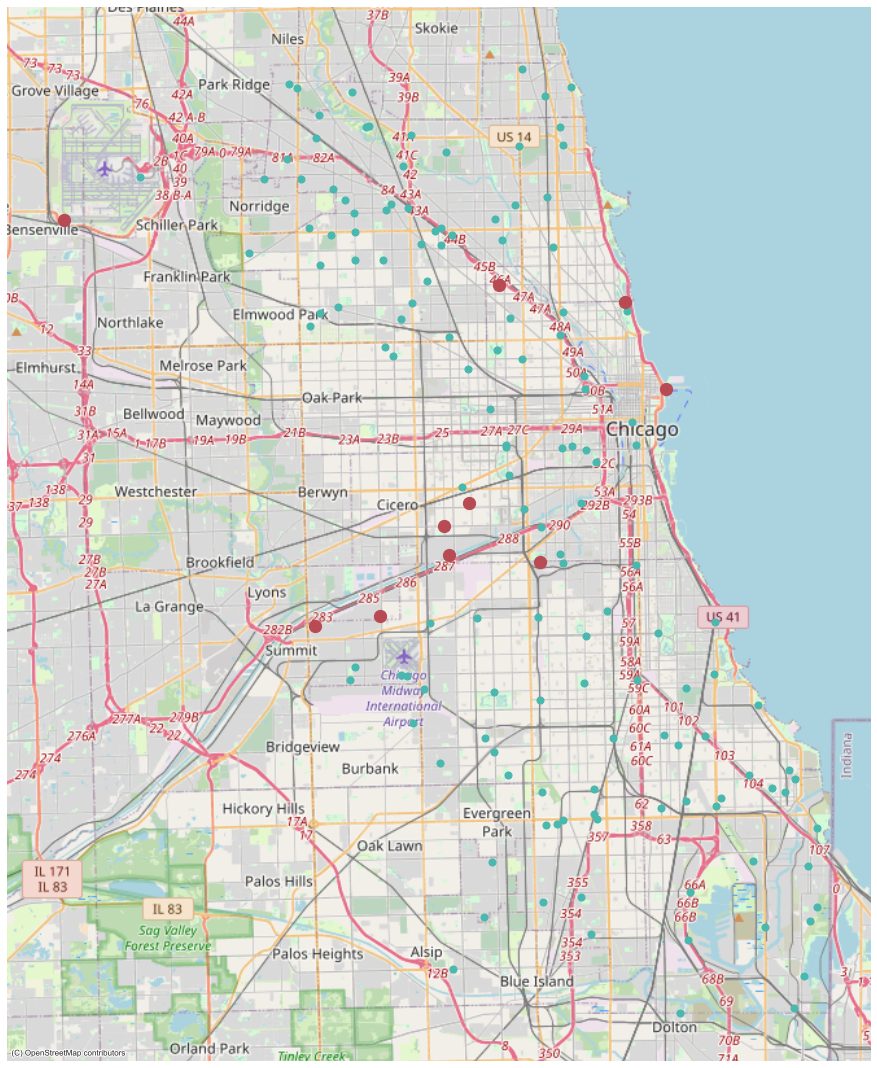

In [42]:
fig, ax = plt.subplots(figsize = (15,15))

p_colors = ["#B84A54", "#49B8AE"]
# Basemap
chicago_map_wm.plot(ax = ax, alpha = 0, edgecolor = 'black', color = 'grey') # plot neighborhood boundaries
cx.add_basemap(ax = ax, source = cx.providers.OpenStreetMap.Mapnik)

predicted_test_df_geo.plot(ax = ax, markersize = 50, color = '#49B8AE')
impt_traps_loc_geo.plot(ax = ax, markersize = 150, color = '#B84A54')

plt.axis('off');

## Result Export

### Export validation set to csv

Export predicted validation set with the predicted NumMosquitos and WnvPresent to csv.

In [694]:
export_df = pd.concat([val_df, predicted_val_df[['NumMosquitos','WnvPresent']]], axis = 1)
export_df.head()

,Id,Date,Species,Trap,Latitude,Longitude,Year,Month,Day of Week,Tmax,Tmin,Tavg,PrecipTotal,Trange,RH,sunlight_hrs,ResultSpeed,is_wet,is_fog,is_smk,Tavg_lag_5,PrecipTotal_lag_5,RH_lag_5,sunlight_hrs_lag_5,ResultSpeed_lag_5,is_wet_lag_5,is_fog_lag_5,is_smk_lag_5,Tavg_lag_6,PrecipTotal_lag_6,RH_lag_6,sunlight_hrs_lag_6,ResultSpeed_lag_6,is_wet_lag_6,is_fog_lag_6,is_smk_lag_6,Tavg_lag_7,PrecipTotal_lag_7,RH_lag_7,sunlight_hrs_lag_7,ResultSpeed_lag_7,is_wet_lag_7,is_fog_lag_7,is_smk_lag_7,Tavg_lag_8,PrecipTotal_lag_8,RH_lag_8,sunlight_hrs_lag_8,ResultSpeed_lag_8,is_wet_lag_8,is_fog_lag_8,is_smk_lag_8,Tavg_lag_9,PrecipTotal_lag_9,RH_lag_9,sunlight_hrs_lag_9,ResultSpeed_lag_9,is_wet_lag_9,is_fog_lag_9,is_smk_lag_9,Tavg_lag_10,PrecipTotal_lag_10,RH_lag_10,sunlight_hrs_lag_10,ResultSpeed_lag_10,is_wet_lag_10,is_fog_lag_10,is_smk_lag_10,Tavg_lag_11,PrecipTotal_lag_11,RH_lag_11,sunlight_hrs_lag_11,ResultSpeed_lag_11,is_wet_lag_11,is_fog_lag_11,is_smk_lag_11,Tavg_lag_12,PrecipTotal_lag_12,RH_lag_12,sunlight_hrs_lag_12,ResultSpeed_lag_12,is_wet_lag_12,is_fog_lag_12,is_smk_lag_12,NumMosquitos,WnvPresent
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,2,86,61,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0,16.03,0.0
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,2,86,61,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0,6.39,0.0
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,2,86,61,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0,7.58,0.0
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,6,2,86,61,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0,0.01,0.0
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,6,2,86,61,74,0.0,25,53.405643,910.0,-9.717472,0,0,0,80.0,0.01,66.862387,906.0,-21.368177,1.0,0.0,0.0,74.0,0.64,81.563738,906.0,-13.914161,0.0,1.0,0.0,66.0,0.01,78.155573,904.0,4.659798,1.0,1.0,1.0,62.0,0.52,77.822694,903.0,8.244257,1.0,1.0,0.0,71.0,0.01,51.063734,901.0,1.925667,1.0,0.0,0.0,64.0,0.0,53.95287,901.0,0.34396,0.0,0.0,0.0,69.0,0.0,63.268,899.0,-0.757986,0.0,0.0,0.0,66.0,0.4,78.155573,898.0,-9.979526,1.0,1.0,0.0,0.03,0.0


In [695]:
export_df.to_csv('../../datasets/cleaned_data/predicted_test.csv', index = False)

In [696]:
feature_impt_reg.sort_values(by = 'Feature Importance', ascending = False).head(50).to_csv('../../datasets/cleaned_data/regression_feature_impt.csv', index = False)

In [697]:
feature_impt_classification.sort_values(by = 'Feature Importance', ascending = False).head(50).to_csv('../../datasets/cleaned_data/classification_feature_impt.csv', index = False)

### Kaggle Submission Export

In [601]:
kaggle_sub_df = pd.DataFrame({"Id": val_df_processed['Id'].values, "WnvPresent": predict_val})

In [602]:
kaggle_sub_df.head()

,Id,WnvPresent
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [603]:
kaggle_sub_df['WnvPresent'].value_counts()

0.0    102561
1.0     13732
Name: WnvPresent, dtype: int64

In [604]:
kaggle_sub_df.to_csv("../../datasets/cleaned_data/kaggle_submission.csv", index = False)

In [ ]:

# lag features one by one